<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF - 477  Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Andrea Freire - Francisco Sáez </H3>
<hr style="height:2px;border:none"/>

# 2. RNN sobre texto

Hoy en día, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (_Groningen Meaning Bank_), para reconocimientos de entidades y tagger. En específico, trabajaremos con el dataset proporcionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millon de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />

In [ ]:
# Paquetes a utilizar 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import random

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
from sklearn_crfsuite.metrics import flat_classification_report 
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report

### 2.a Carga de datos y preprocesamiento

i) Investigue en la documentación del dataset cual es la tarea original para la cual fue propuesto, en particular cuál es la variable que buscamos predecir, a qué se refiere esta misma y por qué es necesario utilizar técnicas avanzadas para resolver esta tarea (¿no bastaría con un diccionario?).

Cargue el conjunto de datos. Este conjunto de datos es bastante grande, por lo que como ven en el código propuesto, nos contentaremos con no consideras lineas corruptas del registro. 

En esta primera instancia trabajaremos en la tarea de realizar un NER tag (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo _many to many_, es decir, la entrada es una secuencia y la salida es una secuencia, sin _shift_, por lo que necesitaremos una estructura de red adecuada a esto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar _lemma_ en vez de la palabra misma word?**

**Respuesta**:

- El dataset es un corpus comentado para el reconocimiento de entidades nombradas utilizando el corpus de GMB para la clasificación de entidades con características mejoradas y populares por el Procesamiento de Lenguaje Natural.
- Este dataset permite elegir entidades con nombres personalizados e intencionales de tu propia frase con más características, ayuda a resolver problemas reales de negocio (como elegir entidades de los registros médicos electrónicos)
- Se trata de predecir el tag, donde según las siglas que se le de tiene un significado, por ejemplo, el target org hace referencia a una organización. Entonces se le puede dar un significado a cada palabra a través del target. Se utilizan técnicas avanzadas para poder predecir grandes cantidades de target de forma eficiente. 
- Se utiliza el lemma en vez de la misma word porque el lemma entrega la palabra sin conjugación.

In [ ]:
username="franciscosez"
key="0e59031301a9a8d786e9dab505d5f7d5"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
if not os.path.exists("/content/NER"):
    os.makedirs("/content/NER")
os.chdir('/content/NER')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

 61% 16.0M/26.4M [00:00<00:00, 68.8MB/s]
100% 26.4M/26.4M [00:00<00:00, 87.6MB/s]
entity-annotated-corpus.zip  ner.csv  ner_dataset.csv


In [ ]:
df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,['lemma','tag','word','sentence_idx']]
dataset[:20]

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,tag,word,sentence_idx
0,thousand,O,Thousands,1.0
1,of,O,of,1.0
2,demonstr,O,demonstrators,1.0
3,have,O,have,1.0
4,march,O,marched,1.0
5,through,O,through,1.0
6,london,B-geo,London,1.0
7,to,O,to,1.0
8,protest,O,protest,1.0
9,the,O,the,1.0


II) Para poder utilizar este conjunto de datos, debemos transformar nuestra tabla de palabras y sentencias, a una tabla donde cada entrada sea una sentencia, además condificando los distintos lemmas y tags como valores numéricos. Esto pueden realizarlo con alguna de las utilidades de keras o sklearn, sin embargo en el código siguiente se propone un método solo utilizando python y pandas. Pueden utilizar el método que deseen. Note eso si que independiente la aproximación que utilice debe comenzar desde 1 para la codificación, pues el valor 0 lo reservamos para representar la ausencia de palabras más adelante.

In [ ]:
# Enumera cada uno de los lemma en orden secuencial
lemma_to_code = {lemma: code+1 for code, lemma in enumerate(dataset.lemma.unique())}

# Enumera los tag
tag_to_code   = {tag:code+1 for code, tag in enumerate(dataset.tag.unique())}

# Número de lemmas
n_lemmas      = len(lemma_to_code)
n_tag         = len(tag_to_code)

# Se cambia en el dataset el lemma y tag por la codificación hecha
dataset['lemma'] = dataset.lemma.apply(lambda x: lemma_to_code[x])
dataset['tag']   = dataset.tag.apply(lambda x: tag_to_code[x])

# Se arma el dataset, donde cada entrada corresponde a una sentencia formada de lemmas
# con su respectiva codificación y el tag es la codificación del tag de cada lemma
dff = dataset.groupby("sentence_idx")[['lemma','tag']].agg(list).applymap(np.asarray)

### 2.b) Distribuciones

Ahora que tenemos las sentencias codificadas y agrupadas, explore el tamaño de estas, en número de lemmas: ¿Son todas las sentencias de igual tamaño?¿Le hace sentido esto?¿Las redes que conocen pueden manejar ejemplo de distintos tamaños, y si pueden qué problemas podrían traer?¿Están las clases repartidas de manera equitativa?

Estudie la distribución del largo de los textos a procesar. Esudie tambien la frencuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?** Realice un gráfico de la cantidad de datos por clase. Comente.

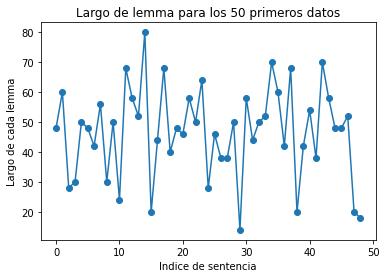

In [ ]:
# Largo de cada lemma
len_lemma = [len(dff['lemma'][i]) for i in range(1,50) ]
plt.plot(len_lemma,'-o')
plt.xlabel('Indice de sentencia')
plt.ylabel('Largo de cada lemma')
plt.title('Largo de lemma para los 50 primeros datos')
plt.show()

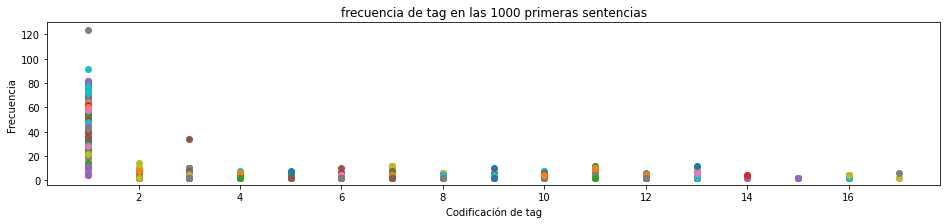

In [ ]:
fre_tag = [np.unique(dff['tag'][i], return_counts=True) for i in range(1,1000)]

for frecuencia in fre_tag:
  plt.plot(frecuencia[0], frecuencia[1],'o')

plt.xlabel('Codificación de tag')
plt.ylabel('Frecuencia')
plt.title('frecuencia de tag en las 1000 primeras sentencias')
plt.show()

In [ ]:
print('El tag que más se repite corresponde a O')

El tag que más se repite corresponde a O


**Comentarios:**
- Se puede ver que no todas las sentencias tienen igual tamaño, lo que tiene sentido dado es el reflejo de la vida real donde dependiendo lo que se quiere comunicar la sentencia tiene diferentes palabras y diferentes largos. 
- Para el caso de la red feed forward esta no puede ser entrenada con ejemplos de diferentes largos dado que el tamaño de las neuronas de entrada no se modifica a lo largo del entrenamiento. Quizás una solución puede ser considerar el tamaño máximo de un lemma como la cantidad de neuronas de entrada y rellenar con ceros las demas sentencias para que tengan el mismo largo, pero se puede considerar una mala práctica.
- Se puede apreciar la ley de Zipf, dado que la palabra etiqueta con 1 como target es la que mayor frecuencia tiene en la mayoría de las sentencias. 


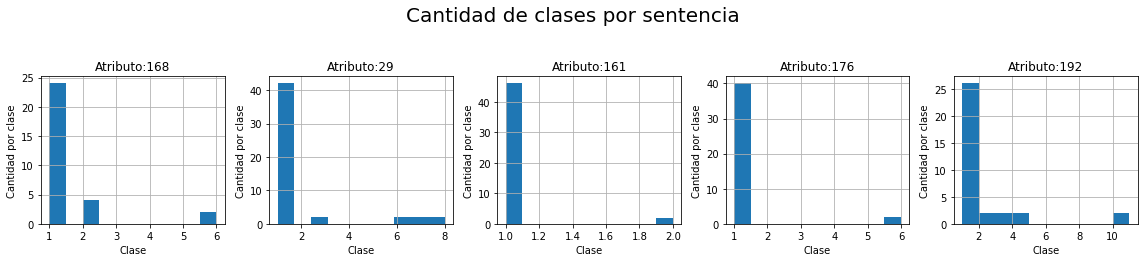

In [ ]:
num = np.random.randint(200, size=(5))
class_tag = [dff['tag'][i] for i in num ]

plt.rcParams['figure.figsize'] = [16,3]
plt.suptitle('Cantidad de clases por sentencia', size = 20, y = 1.2)
k=1
for i in range(1,6):
  plt.subplot(1,5,k)
  plt.title('Atributo:'+str(num[i-1]))
  plt.hist(class_tag[i-1])
  plt.tight_layout()
  plt.grid()
  plt.xlabel('Clase')
  plt.ylabel('Cantidad por clase')
  if k == 5:
    k = 1
    plt.show()
  else: 
    k += 1

**Comentarios:** se púede ver que en las diferentes sentencias la clase mayoritaria es la 1.

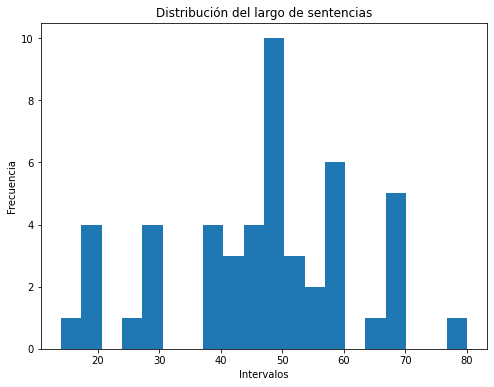

In [ ]:
# Distribución del largo
plt.rcParams['figure.figsize'] = [8,6]
plt.hist(len_lemma,20)
plt.xlabel('Intervalos')
plt.ylabel('Frecuencia')
plt.title('Distribución del largo de sentencias')
plt.show()

### 2.c) Padding y one hot vectors

i) En esta parte de la tarea, deben lograr que todas las secuencias de lemmas (y los tags correspondientes) queden del mismo largo, es decir realizar padding. El padding debe realizarse con el valor 0, pueden escoger si realizarlo al comienzo de la secuencia o al final, explique su elección. Pueden utilizar la función de keras o escribir su propio código. Elija un valor de maxlen que le parezca adecuado.

¿Opinan que es deseable utilizar el valor 0 como codificación de la palabras "no existen", o creen que es irrelevante por ejemplo que su valor sea 1?

In [ ]:
# Generar Dataset
X = pad_sequences(dff['lemma'], padding='post')
Y = pad_sequences(dff['tag'],padding='post')

**Comentarios:**
- El cero es el número indicado para codificar la no existencia de una palabra, esto debido a que el cero no tienen ninguna validez numéricamente hablando lo que refleja la ausencia de algo, en este caso, la ausencia de las palabras.
- Se mantuvo el maxlen por defecto para hacer calzar el shape de los set según el enunciado.

II) Para poder entregar una clasificación sobre los distintos tags es necesario transformarlos a _one hot vectors_, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles tags. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación.

In [ ]:
# Generar one hot vector de target
y = np.asarray([to_categorical(i, num_classes = n_tag+1) for i in Y])

In [ ]:
# Separar conjunto de datos
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
# Tamaño de los conjuntos
x_tr.shape,y_tr.shape,x_val.shape,y_val.shape

((26382, 140), (26382, 140, 18), (8795, 140), (8795, 140, 18))

**Comentarios:**
- Se puede ver que x_tr y x_val tienen forma (N de ejemplos, largo de sentencia), mientras que y_tr e y_val tienen la forma (N de ejemplos, largo de secuencia, N de tag)


### 2.d) RNN many to many

I) Defina una red neuronal recurrente many to many con compuertas LSTM para aprender a tagear la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de _lemmas_ rellenados (o sin rellenar) y entregar el _tag_ a cada uno de los _lemmas_, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimension extra la cual es debido a que en cada instante de tiempo se necesita entregar un _output_. Como los _lemmas_ corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

In [ ]:
model_2d        = Sequential()
embedding_dim   = 32
model_2d.add(Embedding(input_dim = x_tr.shape[0], output_dim = embedding_dim, input_length= x_tr.shape[1] ))
model_2d.add(LSTM(units = 128, return_sequences= True ))
model_2d.add(Dense(18, activation = 'softmax'))
model_2d.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

history_2d = model_2d.fit(x_tr, y_tr, validation_data = (x_val, y_val), epochs = 3, batch_size = 128)

Epoch 1/3
207/207 [==============================] - 90s 427ms/step - loss: 0.9062 - acc: 0.8350 - val_loss: 0.1849 - val_acc: 0.9658
Epoch 2/3
207/207 [==============================] - 86s 414ms/step - loss: 0.1713 - acc: 0.9664 - val_loss: 0.1139 - val_acc: 0.9692
Epoch 3/3
207/207 [==============================] - 86s 416ms/step - loss: 0.1038 - acc: 0.9710 - val_loss: 0.0855 - val_acc: 0.9751


Para evaluar su modelo utilice una métrica adecuada para el desbalance presente entre las clases

In [ ]:
y_pred = (model_2d.predict(x_val)>0.5)*1

In [ ]:
f1        = []
precision = []
recall    = []
for i in range(0,n_tag+1):
  f1.append(classification_report(y_val[:,:,i], y_pred[:,:,i],
                                  zero_division=1,output_dict=True)['macro avg']['f1-score'])
  precision.append(classification_report(y_val[:,:,i], y_pred[:,:,i],
                                         zero_division=1,output_dict=True)['macro avg']['precision'])
  recall.append(classification_report(y_val[:,:,i], y_pred[:,:,i],
                                         zero_division=1,output_dict=True)['macro avg']['recall'])

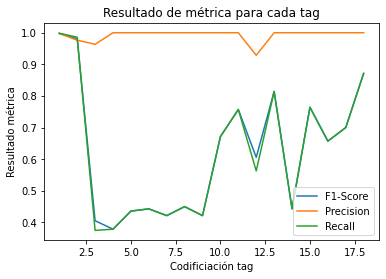

In [ ]:
# Gráfico de métricas
plt.plot(range(1,n_tag+2),f1, label='F1-Score')
plt.plot(range(1,n_tag+2),precision, label='Precision')
plt.plot(range(1,n_tag+2),recall, label='Recall')
plt.xlabel('Codificiación tag')
plt.ylabel('Resultado métrica')
plt.title('Resultado de métrica para cada tag')
plt.legend()
plt.show()

II) Varíe la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente:

In [ ]:
def RNN_many(embedding):
  model          = Sequential()
  embedding_dim  = embedding
  model.add(Embedding(input_dim = x_tr.shape[0], output_dim = embedding_dim, input_length= x_tr.shape[1] ))
  model.add(LSTM(units = 128, return_sequences= True ))
  model.add(Dense(18, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

  history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), epochs = 3, batch_size = 128,
                      verbose = 0)

  return [history.history['val_acc'], history.history['val_loss']]

In [ ]:
# Ajustar red variando embedding
embedding = [2, 32, 128]
result_em = []

for i in embedding:
  result_em.append(RNN_many(i))

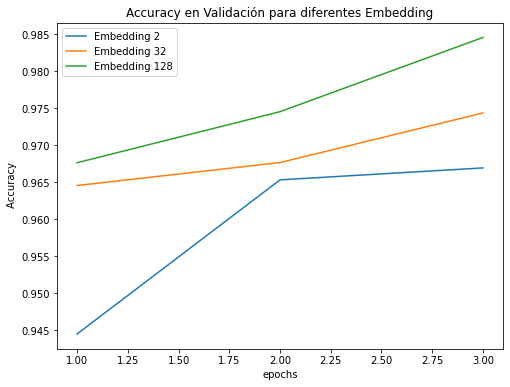

In [ ]:
# Gráfico Accuracy
plt.rcParams['figure.figsize'] = [8,6]
for i in range(len(result_em)):
  plt.plot(range(1,4),result_em[i][0], label='Embedding'+' '+str(embedding[i]))
plt.xlabel('epochs')
plt.ylabel(' Accuracy')
plt.title('Accuracy en Validación para diferentes Embedding')
plt.legend()
plt.show()

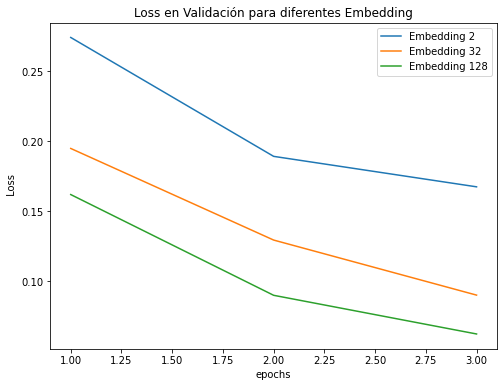

In [ ]:
# Gráfico Accuracy
plt.rcParams['figure.figsize'] = [8,6]
for i in range(len(result_em)):
  plt.plot(range(1,4),result_em[i][1], label='Embedding'+' '+str(embedding[i]))
plt.xlabel('epochs')
plt.ylabel(' Loss')
plt.title('Loss en Validación para diferentes Embedding')
plt.legend()
plt.show()

**Comentarios:**
- Se puede ver que aumentar el Embedding mejora el resultado obtenido en el entrenamiento de la red de manera considerable.

### 2.e) RNN Bidireccional y masking

I) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. **Mejore la red definida en 2.d.I) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de _lemmas_ de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro _merge_mode_** (concatenar, multiplicar, sumar o promediar) para este caso. Además, comente las transformaciones que subre el patrón de entrada al pasar por las capas.  **¿Mejora o empeora el desempeño?** Analice.

El parámetro `merge_mode` se puede clasificar en tres categorias.
- Suma y promedio son combinaciones lineales. Esto es usado porque el gradiente es más facil de trabajar con suma y resta. Un uso comun de esto es cuando se suman varios criterios juntos para obtener una función de pérdida para una NN que entrena multiples tareas de forma conjunta.
- Multiplicación es utilizado para determinar que tan similares son dos o mas vectores respecto al otro.
- Concatenación no descarga ningún input. Una práctica habitual de esto es cuando se concatena el esta escondido con la salida de una red recurrente alimentando una capa densa como es el caso que se presenta. Por lo tanto se utiliza concatenación.

In [ ]:
# Segundo modelo
model_2e = Sequential()
model_2e.add(Embedding(input_dim = x_tr.shape[0], output_dim = embedding_dim, input_length= x_tr.shape[1] ))
layer_lstm = LSTM(units = 128, return_sequences= True )
model_2e.add(Bidirectional(layer_lstm, merge_mode = 'concat'))
model_2e.add(Dense(18, activation = 'softmax'))
model_2e.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['acc'])

history_2e = model_2e.fit(x_tr,y_tr, validation_data = (x_val, y_val), epochs = 3, batch_size = 128)

Epoch 1/3
207/207 [==============================] - 156s 738ms/step - loss: 0.7732 - acc: 0.8674 - val_loss: 0.1678 - val_acc: 0.9661
Epoch 2/3
207/207 [==============================] - 151s 729ms/step - loss: 0.1642 - acc: 0.9661 - val_loss: 0.1200 - val_acc: 0.9680
Epoch 3/3
207/207 [==============================] - 150s 726ms/step - loss: 0.1038 - acc: 0.9710 - val_loss: 0.0750 - val_acc: 0.9771


In [ ]:
# Summary 
model_2d.summary()
model_2e.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 32)           844224    
_________________________________________________________________
lstm (LSTM)                  (None, 140, 128)          82432     
_________________________________________________________________
dense (Dense)                (None, 140, 18)           2322      
Total params: 928,978
Trainable params: 928,978
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 32)           844224    
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 256)          164864    
____________________________

Text(0.5, 1.0, 'Loss')

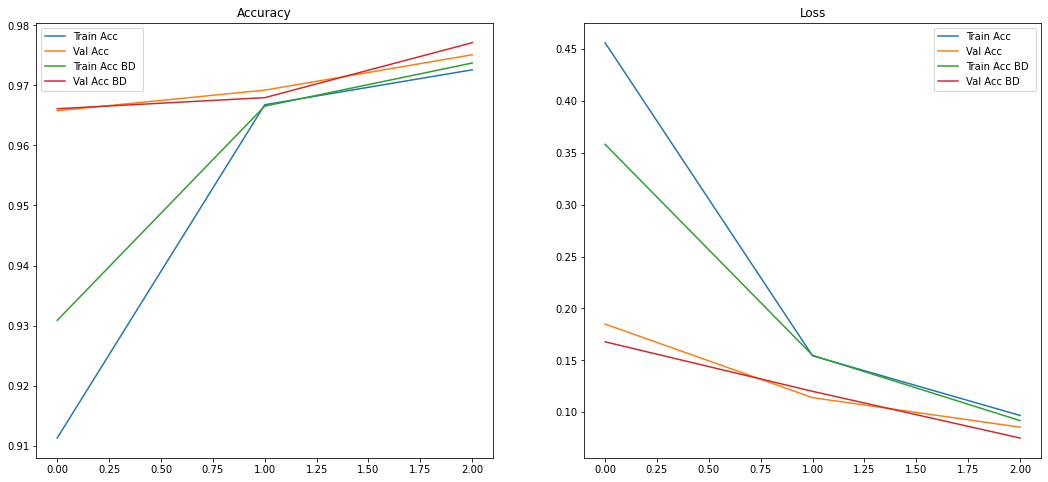

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [18,8]
plt.subplot(1,2,1)
plt.plot(history_2d.history['acc'], label = 'Train Acc ')
plt.plot(history_2d.history['val_acc'], label = 'Val Acc')
plt.plot(history_2e.history['acc'], label = 'Train Acc BD ')
plt.plot(history_2e.history['val_acc'], label = 'Val Acc BD')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_2d.history['loss'], label = 'Train Acc ')
plt.plot(history_2d.history['val_loss'], label = 'Val Acc')
plt.plot(history_2e.history['loss'], label = 'Train Acc BD ')
plt.plot(history_2e.history['val_loss'], label = 'Val Acc BD')
plt.legend()
plt.title('Loss')

**Comentarios:**
- Se puede ver que el uso de una red bidireccional mejora el desempeño de la red en comparación a una LSTM clásica. Además, se puede ver que utilizar `merge_mode` como concatenación, permitío mejorar el desempeño sobre el mismo dataset.

II) Recientemente se ha implementado la capa de _Masking_ en las redes recurrentes en _keras_, lo cual podría traer gran ayuda gracias al _padding_ que se realiza con el símbolo especial definido. Entrene la red definida en 2.d.I) y compare al utilizar esta funcionalidad de enmascaras el valor de 0 en este caso para el default de la capa embedding.

In [ ]:
# Modelo con masking
model_2eii          = Sequential()
embedding_dim  = 32
model_2eii .add(Embedding(input_dim = x_tr.shape[0], 
                          output_dim = embedding_dim, input_length= x_tr.shape[1], mask_zero = True))
model_2eii .add(LSTM(units = 128, return_sequences= True ))
model_2eii .add(Dense(18, activation = 'softmax'))
model_2eii .compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

history_2eii  = model_2eii .fit(x_tr, y_tr, validation_data = (x_val, y_val), epochs = 3, batch_size = 128)

Epoch 1/3
207/207 [==============================] - 103s 480ms/step - loss: 0.2929 - acc: 0.8187 - val_loss: 0.1058 - val_acc: 0.8539
Epoch 2/3
207/207 [==============================] - 98s 474ms/step - loss: 0.0945 - acc: 0.8716 - val_loss: 0.0779 - val_acc: 0.8970
Epoch 3/3
207/207 [==============================] - 97s 469ms/step - loss: 0.0731 - acc: 0.9019 - val_loss: 0.0663 - val_acc: 0.9118


Text(0.5, 1.0, 'Loss')

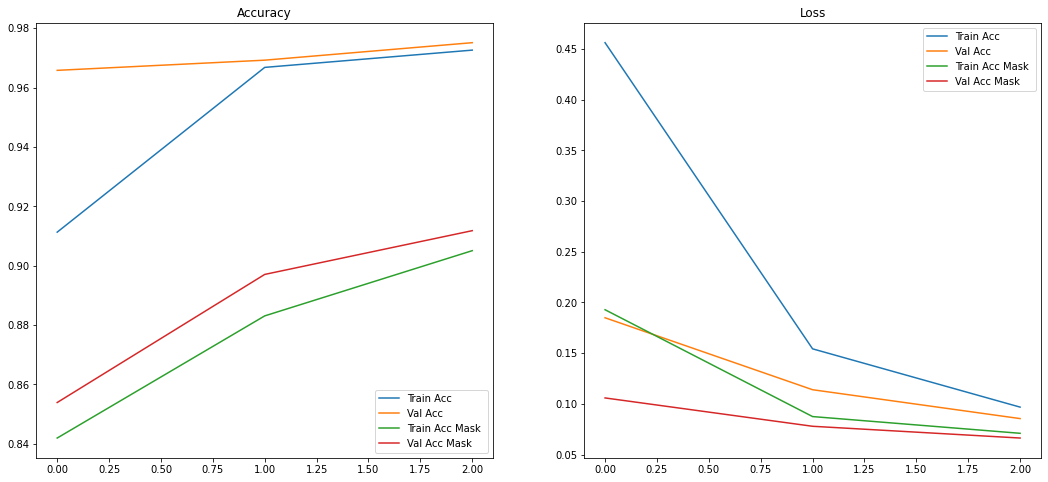

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [18,8]
plt.subplot(1,2,1)
plt.plot(history_2d.history['acc'], label = 'Train Acc ')
plt.plot(history_2d.history['val_acc'], label = 'Val Acc')
plt.plot(history_2eii.history['acc'], label = 'Train Acc Mask ')
plt.plot(history_2eii.history['val_acc'], label = 'Val Acc Mask')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_2d.history['loss'], label = 'Train Acc ')
plt.plot(history_2d.history['val_loss'], label = 'Val Acc')
plt.plot(history_2eii.history['loss'], label = 'Train Acc Mask ')
plt.plot(history_2eii.history['val_loss'], label = 'Val Acc Mask')
plt.legend()
plt.title('Loss')

In [ ]:
y_pred_2d   = model_2d.predict(x_val)>0.5
y_pred_2eii = model_2eii.predict(x_val)>0.5

In [ ]:
f1_2eii         = []
precision_2eii  = []
recall_2eii     = []
for i in range(0,n_tag+1):
  f1_2eii.append(classification_report(y_val[:,:,i], y_pred_2eii[:,:,i],
                                  zero_division=1,output_dict=True)['macro avg']['f1-score'])
  precision_2eii.append(classification_report(y_val[:,:,i], y_pred_2eii[:,:,i],
                                         zero_division=1,output_dict=True)['macro avg']['precision'])
  recall_2eii.append(classification_report(y_val[:,:,i], y_pred_2eii[:,:,i],
                                         zero_division=1,output_dict=True)['macro avg']['recall'])

Text(0.5, 1.0, 'Métrica Recall')

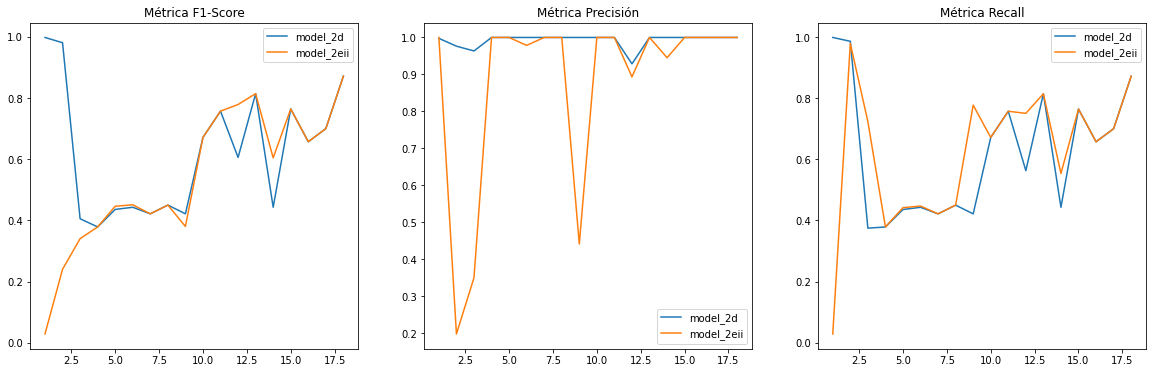

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [20,6]
plt.subplot(1,3,1)
plt.plot(range(1,n_tag+2),f1, label='model_2d')
plt.plot(range(1,n_tag+2),f1_2eii, label='model_2eii')
plt.legend()
plt.title('Métrica F1-Score')

plt.subplot(1,3,2)
plt.plot(range(1,n_tag+2),precision, label='model_2d')
plt.plot(range(1,n_tag+2),precision_2eii, label='model_2eii')
plt.legend()
plt.title('Métrica Precisión')

plt.subplot(1,3,3)
plt.plot(range(1,n_tag+2),recall, label='model_2d')
plt.plot(range(1,n_tag+2),recall_2eii, label='model_2eii')
plt.legend()
plt.title('Métrica Recall')

### 2.f) Mejora Libre

En base a lo experimentado, **Intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítems, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de _padding_ o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra _gate_ de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras. Utilice la red entrenada, **se espera que sea la mejor de esta sección y muestre las predicciones**, el _NER tager_, sobre algún ejemplo de pruebas, comente.

In [ ]:
# Generar Dataset
X_2f = pad_sequences(dff['lemma'], padding='post',maxlen=80)
Y_2f = pad_sequences(dff['tag'],padding='post',maxlen=80)

y_2f = np.asarray([to_categorical(i, num_classes = n_tag+1) for i in Y_2f])
x_tr, x_val, y_tr, y_val = train_test_split(X_2f, y_2f, test_size=0.25, random_state=1)
x_tr.shape,y_tr.shape,x_val.shape,y_val.shape

((26382, 80), (26382, 80, 18), (8795, 80), (8795, 80, 18))

In [ ]:
# Segundo modelo
model_2e = Sequential()
model_2e.add(Embedding(input_dim = x_tr.shape[0], output_dim = embedding_dim, input_length= x_tr.shape[1] ))
layer_lstm = LSTM(units = 128, return_sequences= True )
model_2e.add(Bidirectional(layer_lstm, merge_mode = 'concat'))
model_2e.add(Dense(18, activation = 'softmax'))
model_2e.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['acc'])

history_2e = model_2e.fit(x_tr,y_tr, validation_data = (x_val, y_val), epochs = 5, batch_size = 128)

Epoch 1/5
207/207 [==============================] - 91s 423ms/step - loss: 0.9247 - acc: 0.8032 - val_loss: 0.2747 - val_acc: 0.9430
Epoch 2/5
207/207 [==============================] - 88s 425ms/step - loss: 0.2427 - acc: 0.9436 - val_loss: 0.1446 - val_acc: 0.9574
Epoch 3/5
207/207 [==============================] - 88s 426ms/step - loss: 0.1316 - acc: 0.9603 - val_loss: 0.1011 - val_acc: 0.9720
Epoch 4/5
207/207 [==============================] - 87s 422ms/step - loss: 0.0877 - acc: 0.9760 - val_loss: 0.0765 - val_acc: 0.9790
Epoch 5/5
207/207 [==============================] - 86s 415ms/step - loss: 0.0636 - acc: 0.9822 - val_loss: 0.0658 - val_acc: 0.9814


In [ ]:
# Mejora
model_2f = Sequential()
model_2f.add(Embedding(input_dim = x_tr.shape[0], output_dim = embedding_dim,
                       input_length= 80 ))
layer_lstm = LSTM(units = 256, return_sequences= True )
model_2f.add(Bidirectional(layer_lstm, merge_mode = 'concat'))
model_2f.add(Dense(18, activation = 'softmax'))
model_2f.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['acc'])

history_2f = model_2f.fit(x_tr,y_tr, validation_data = (x_val, y_val), epochs = 5, batch_size = 128)

Epoch 1/5
207/207 [==============================] - 223s 1s/step - loss: 0.7963 - acc: 0.8158 - val_loss: 0.2435 - val_acc: 0.9432
Epoch 2/5
207/207 [==============================] - 220s 1s/step - loss: 0.1967 - acc: 0.9476 - val_loss: 0.1233 - val_acc: 0.9629
Epoch 3/5
207/207 [==============================] - 217s 1s/step - loss: 0.1086 - acc: 0.9685 - val_loss: 0.0865 - val_acc: 0.9764
Epoch 4/5
207/207 [==============================] - 217s 1s/step - loss: 0.0708 - acc: 0.9802 - val_loss: 0.0676 - val_acc: 0.9808
Epoch 5/5
207/207 [==============================] - 217s 1s/step - loss: 0.0543 - acc: 0.9844 - val_loss: 0.0625 - val_acc: 0.9825


Text(0.5, 1.0, 'Loss')

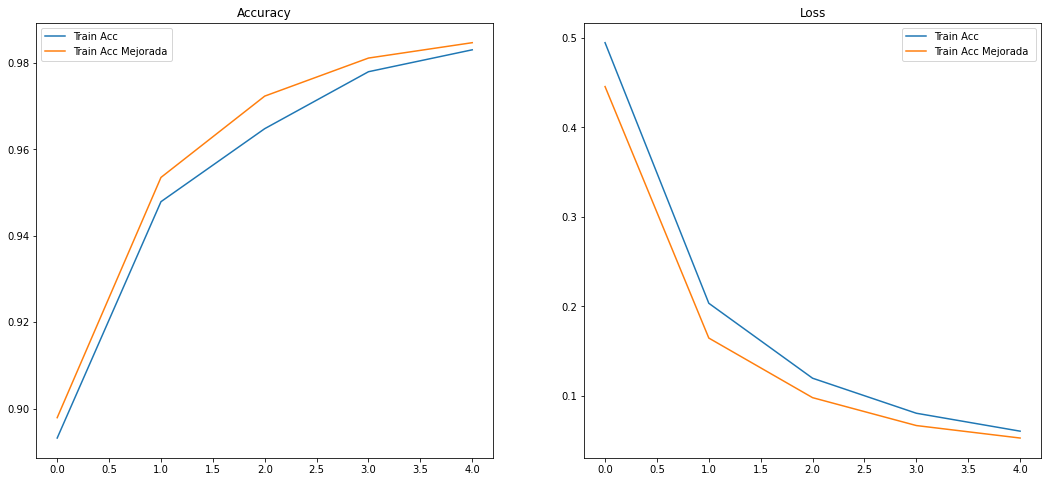

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [18,8]
plt.subplot(1,2,1)
plt.plot(history_2e.history['acc'], label = 'Train Acc ')
plt.plot(history_2f.history['acc'], label = 'Train Acc Mejorada')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_2e.history['loss'], label = 'Train Acc ')
plt.plot(history_2f.history['loss'], label = 'Train Acc Mejorada ')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

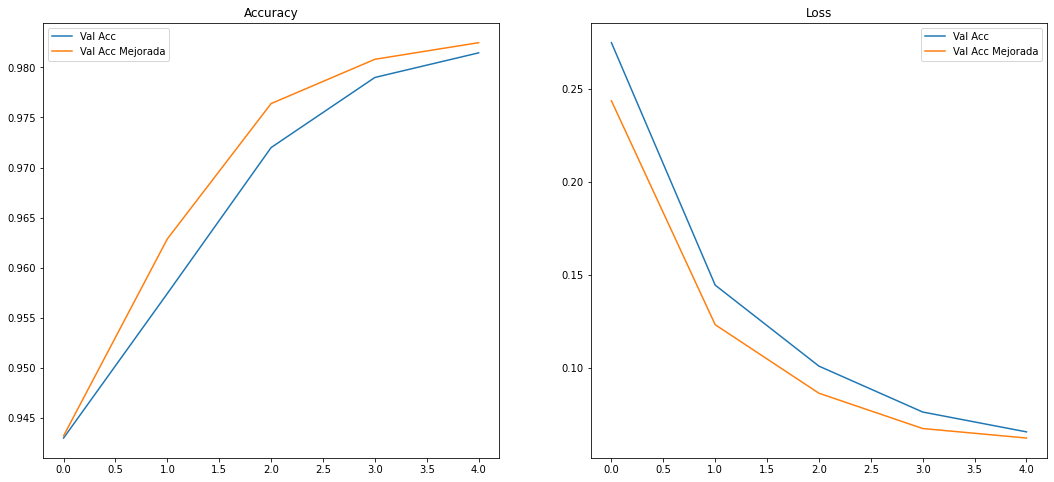

In [ ]:
## Gráficos
plt.rcParams["figure.figsize"] = [18,8]
plt.subplot(1,2,1)
plt.plot(history_2e.history['val_acc'], label = 'Val Acc')
plt.plot(history_2f.history['val_acc'], label = 'Val Acc Mejorada')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_2e.history['val_loss'], label = 'Val Acc')
plt.plot(history_2f.history['val_loss'], label = 'Val Acc Mejorada')
plt.legend()
plt.title('Loss')

**Comentarios:** se puede apreciar que existe una mejora tanto en el train como en el validation set.

## 2.g) Escribamos Palabras

i) Ahora buscaremos otra aplicación a las redes recurrentes, predecir el caracter siguiente. Si logramos entrenar una red que sea buena en esta tarea, podremos escribir texto automáticamente, pues podemos, a partir de una frase, predecir el caracter siguiente y luego introducir la nueva frase sin el primer caracter en la red nuevamente e iterando asi escribir automáticamente. Si bien las redes recurrentes son adecuadas para esta tarea, no pretendemos entrenar un Shakespeare en esta tarea, sin embargo es interesante investigar qué tan verosímil o no puede lograr ser el texto generado.

Para esto, primero crearemos nuestro nuevo dataset. Para esta tarea preferiremos unir todas las frases en un solo gran corpus y luego crear nuevas secuencias semi redundantes. Esto nos evita primero el problema de tener que hacer padding, pues crearemos todas las entradas iguales, pero también nos permite aprovechar mejor el dataset, de cierta forma aumentando el número de datos. El target en este caso será solo el caracter siguiente correspondiente a cada secuencia. 

En este ítem debe cargar el dataset. **Explique lo que hace el código entregado**

In [ ]:
# Carga dataset
df_w = pd.read_csv(os.path.join('ner.csv'), engine = 'python', error_bad_lines= False)

# Se deja solamente las palabras
df_w = df_w.dropna()[['word']]

Skipping line 281837: Expected 25 fields in line 281837, saw 34


In [ ]:
# Se escribe un texto con las palabras
corpus = ' '.join(list(df_w.word.values)).lower()

# Inputs de tamaño y pasos y listas para guardar
sentence_length = 40
steps           = 5
sentences = []
next_char = []

for i in range(0, len(corpus)- sentence_length-1, steps):
  # Se generan sentencias de largo 40 cada 5 palabras
  sentences.append(corpus[i:sentence_length+i])
  # Guarda el caracter siguiente a la sentencia escogida
  next_char.append(corpus[sentence_length+i])

# Se le asigna un número a cada caracter
chars_to_code = {char:code for code, char in enumerate(set(corpus))}
# Se ordena el código de cada caracter
code_to_chars = {code:char for char, code in chars_to_code.items()}
# Se crea dataset (x,y)
x = np.array([[chars_to_code[char] for char in sentence]for sentence in sentences])
y = np.array([chars_to_code[char]for char in next_char])
y = to_categorical(y)

# x contiene la sentencia de largo 40 donde cada entrada corresponde a
# un caracter codificado e y contiene el siguiente caracter

II) Entrene ahora una red con estos datos utilizando GRU. El resto de la estructura queda a su elección. Evalúe el desempeño de su red evaluando qué tan bien genera texto, puede utilizar las funciones propuestas como callback para ver como progresa su red. Prueba al menos 2 estructuras distintas.

Una vez que este satisfecho de su red, hágala escribir algunos textos a partir de textos semillas elegidos por usted. Describa sus observaciones. ¿Qué cree que ocurriría si entrenamos la red con otro dataset?

In [ ]:
def predict_char(model,sentence):
  # Crear inputs
  x = [chars_to_code[char] for char in sentence]
  x = pad_sequences([x], maxlen = sentence_length, padding = 'pre', value = 0)

  # Predicción
  probas     = model.predict(x)[0]
  next_index = np.random.choice(len(chars_to_code), p=probas)

  return code_to_chars[next_index]

def on_epoch_end(epoch, logs):
  print(f'\n Generating random text for epoch: {epoch}')
  start_index = random.randint(0, x.shape[0]-1)
  sentence    = ''.join([code_to_chars[code] for code in x[start_index]])
  print('\n Generating with seed: ' + sentence)
  sys.stdout.write(sentence)
  for i in range(400):
    next_char = predict_char(character, sentence)
    sentence = sentence[1:]+next_char              # For next character
    sys.stdout.write(next_char)
    sys.stdout.flush()
  return

print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
character = Sequential()
embedding_dim = 100
character.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character.add(GRU(128, return_sequences= False))
character.add(Dense(y.shape[1], activation= 'softmax'))
optimizer = RMSprop(lr = 0.01)
character.compile(loss='categorical_crossentropy', optimizer = optimizer,
                  metrics = ["acc"])
character.fit(x,y, epochs = 1, batch_size = 512, callbacks = [print_text_callback])
character.summary()

2371/2371 [==============================] - 703s 296ms/step - loss: 1.8510 - acc: 0.4593

 Generating random text for epoch: 0

 Generating with seed: luding bird flu . the changes , proposed
luding bird flu . the changes , proposed from contraccus in begin and iran . are hhaving her oppered him internation aiditifiting plive , also nation aga nau ' bahown hailihiman occipromian becking the precape rocorment and hotalian edpents koyubal official recess of price it aron whto deportor loke interive expect his hous other in u. on ettaget that refeere have beginio agentines -angrack it ain say overemisser sayst is announcip athrModel: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           6000      
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________

**Comentarios:**
- Se puede ver que la red logra escribir palabras medianamente concordante entre ellas, incluso pudo escribir utilizando punto y coma.